441000
0 0.0 261.63
1 0.0 261.63
2 0.0 261.63
3 0.0 261.63
4 0.0 261.63
5 0.0 261.63
6 0.0 261.63
7 0.0 261.63
8 0.0 261.63
9 0.0 261.63
10 0.0 261.63
11 0.0 261.63
12 0.0 261.63
13 0.0 261.63
14 0.0 261.63
15 0.0 261.63
16 0.0 261.63
17 0.0 261.63
18 0.0 261.63
19 0.0 261.63
20 0.0 261.63
21 0.0 261.63
22 0.0 261.63
23 0.0 261.63
24 0.0 261.63
25 0.0 261.63
26 0.0 261.63
27 0.0 261.63
28 0.0 261.63
29 0.0 261.63
30 0.0 261.63
31 0.0 261.63
32 0.0 261.63
33 0.0 261.63
34 0.00011980420010697791 261.63
35 0.0006969504980440558 261.63
36 0.0008373510709078929 261.63
37 0.0007751147884160391 261.63
38 0.0007873741450299559 261.63
39 0.0008141251781387189 261.63
40 0.0006366010448589437 261.63
41 0.0006602627959683198 261.63
42 0.0005798017622108038 261.63
43 0.0005844938877316159 261.63
44 0.0005209438903124846 261.63
45 0.0005604537001342626 261.63
46 0.0006622985673083255 261.63
47 0.0004324044732260192 261.63
48 0.000458607725723912 261.63
49 0.0004888871865424429 261.63
50 0.0005633052

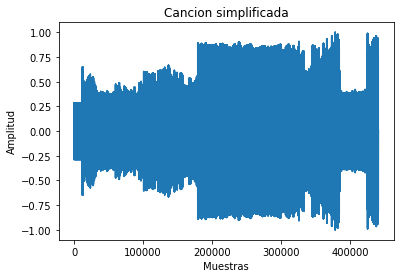

Processed canciones\twinkle-twinkle-little-star-lullaby-164263.mp3 to canciones_simplificadas\twinkle-twinkle-little-star-lullaby-164263 (simplificada).mp3


In [64]:
import numpy as np
import matplotlib.pyplot as plt
import os
from pydub import AudioSegment
from scipy.stats import mode


def read_mp3_file(file_path):
    audio = AudioSegment.from_mp3(file_path)
    samples = np.array(audio.get_array_of_samples())
    sample_width = audio.sample_width
    return samples, sample_width

def convert_to_fp32(audio_data):
    #Graficar la señal de audio despues de normalizar
    audio_fp32 = audio_data.astype(np.float32)
    max_val = np.abs(audio_fp32).max()
    audio_fp32 /= max_val
    # plt.figure("Normalizado")
    # plt.plot(audio_fp32)
    # plt.xlabel('Muestras')
    # plt.ylabel('Amplitud')
    # plt.title('Señal de audio')
    # plt.show()
    return audio_fp32

def split_array(arr, size, overlap=0.5):
    sub_arr = []
    for i in range(0, len(arr), size):
        sub_arr.append(arr[i:i + size])
    return sub_arr[:-1]

# Perform the NUDFT
def nudft(x, frequencies, sampling_rate):
    N = len(x)
    X = np.zeros(len(frequencies), dtype=complex)
    for k, freq in enumerate(frequencies):
        for n in range(N):
            X[k] += x[n] * np.exp(-2j * np.pi * freq * n / sampling_rate)
    return X

def iterative_nudft_max_finder(x, frequencies, sampling_rate, sample_size):
    x_sub = split_array(x, sample_size)
    size = len(x_sub)
    max_list = np.zeros((size, 2))
    for iteration, x_sample in enumerate(x_sub):
        X = np.zeros(len(frequencies), dtype=complex)
        for k, freq in enumerate(frequencies):
            for n, x_aux in enumerate(x_sample):
                X[k] += x_aux * np.exp(-2j * np.pi * freq * n / sampling_rate)
            
        max_value = np.max(np.abs(X))
        max_value_index = frequencies[np.argmax(np.abs(X))]
        max_list[iteration,:]= np.array([max_value, max_value_index])
        print(iteration, max_value, max_value_index)
    return max_list

def generar_cancion_simplificada(x, frequencies, sampling_rate, sample_size):
    print(len(x))
    x_simplificada = np.zeros(len(x))
    max_list = iterative_nudft_max_finder(x, frequencies, sampling_rate, sample_size)
    print(len(x))
    print(len(max_list))
    print(len(max_list)*64)
    t = 1/100 #segundos
    sub_size = np.ceil(t * sampling_rate / sample_size).astype(int)
    sub_max_list = split_array(max_list, sub_size)
    for i, sub_max_list_aux in enumerate(sub_max_list):
        max_value_index = mode(sub_max_list_aux[:,1])[0]
        max_value = np.mean(sub_max_list_aux[:,1])
        for j in range(i * sub_size * sample_size, (i + 1) * sub_size * sample_size):
            x_simplificada[j] = max_value * np.sin(2 * np.pi * max_value_index * j / sampling_rate)
    max_amp = np.abs(x_simplificada).max()
    x_simplificada /= max_amp
    return x_simplificada
    # for i, (max_value, max_value_index) in enumerate(max_list):
    #     for j in range(i * sample_size, (i + 1) * sample_size):
    #         x_simplificada[j] = max_value * np.sin(2 * np.pi * max_value_index * j / sampling_rate)
    # return x_simplificada


def process_directory(input_dir, output_dir):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    for file_name in os.listdir(input_dir):
        if file_name.endswith('.mp3'):
            input_file_path = os.path.join(input_dir, file_name)
            output_file_path = os.path.join(output_dir, os.path.splitext(file_name)[0] + ' (simplificada).mp3')
            samples, sample_width = read_mp3_file(input_file_path)
            audio_fp32 = convert_to_fp32(samples)
            cancion_simple = generar_cancion_simplificada(audio_fp32[:441000], frequencies, sampling_rate, sample_size)
            #plot cancion_simple
            plt.figure("Cancion simplificada")
            plt.plot(cancion_simple)
            plt.xlabel('Muestras')
            plt.ylabel('Amplitud')
            plt.title('Cancion simplificada')
            plt.show()

            #write_to_mp3_file(output_file_path, cancion_simple)

            print(f"Processed {input_file_path} to {output_file_path}")
            return cancion_simple

# Define the fundamental frequencies of the 12 notes from C4 (Do) to B4 (Si)
frequencies = np.array([
    261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88,  # C4 to B4
    523.25, 554.37, 587.33, 622.25, 659.25, 698.46, 739.99, 783.99, 830.61, 880.00, 932.33, 987.77  # C5 to B5
])

sample_size = 64

sampling_rate = 44100  # 44.1 kHz

input_dir = 'canciones'  # Directory containing the input MP3 files

output_dir = 'canciones_simplificadas'  # Directory to save the output MP3 files

cancion_simple = process_directory(input_dir, output_dir)


In [60]:
def write_to_mp3_file(file_path, audio_data):
    #as fp32
    audio_data = (audio_data * (2**31 - 1)).astype(np.int32)
    audio = AudioSegment(audio_data.tobytes(), frame_rate=sampling_rate, sample_width=4, channels=1)
    audio.export(file_path, format='mp3')

write_to_mp3_file('cancion_simplificada.mp3', cancion_simple)
